# Lower bound of $\vartheta^d(G, w)$

## Method 1: seesaw algorithm based on semidefinite programming (applicable to positive weights only)

When all the weights $w_i$ are positive, $\vartheta^d(G, w)$ can also be expressed as

(Eq. 1)
$$\begin{align}
\max_{X}\quad & \lambda_{\max}(M)\\
\mathrm{s.t.}\quad & M_{ii} = w_i,\\
& M_{ij} = 0 ~~ \text{for} ~~ \{i,j\}\in E,\\
& M \ge 0, ~ \mathrm{rank}(M) = d.
\end{align}
$$

This is equivalent to the following optimization in the limit $\varepsilon\to 0^+$

(Eq. 2)
$$\begin{align}
\max_{M, X}\quad & \varepsilon^{-1}(\mathrm{Tr}(MX) - \sum_{i=1}^n w_i)\\
\mathrm{s.t.} \quad & M \ge 0, ~ M_{ii} = w_i,\\
& M_{ij} = 0 ~~ \text{for} ~~ {i,j}\in E,\\
& \lambda(X) = (1 + \varepsilon, \underbrace{1,\dots,1}_{d-1~\text{times}},\underbrace{0,\dots,0}_{n-d~\text{times}}).
\end{align}
$$

This can be solved by alternatingly performing the following two optimization problems

(Eq. 3)
$$\begin{align}
\max_{M}\quad & \varepsilon^{-1}(\mathrm{Tr}(MX_\star) - \sum_{i=1}^n w_i)\\
\mathrm{s.t.} \quad & M \ge 0, ~ M_{ii} = w_i,\\
& M_{ij} = 0 ~~ \text{for} ~~ \{i,j\}\in E.\\
\end{align}
$$

(Eq. 4)
$$\begin{align}
\max_{X, Y}\quad & \varepsilon^{-1}(\mathrm{Tr}(M_\star X) - \sum_{i=1}^n w_i)\\
\mathrm{s.t.} \quad & \lambda(X) = (1 + \varepsilon, \underbrace{1,\dots,1}_{d-1~\text{times}},\underbrace{0,\dots,0}_{n-d~\text{times}}).
\end{align}
$$

In [1]:
import numpy as np
import cvxpy as cvx
import networkx as nx
import scipy.linalg as lin
from scipy.stats import unitary_group, ortho_group

w = [1. 1. 1. 1. 1. 1. 1. 1. 1.]


/tmp/ipykernel_23049/1532849509.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  G = nx.adjacency_matrix(graph, dtype=float).todense()


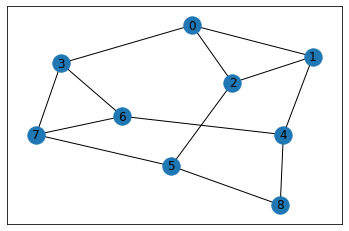

In [2]:
# Define the graph (in graph6 format)
graph = nx.from_graph6_bytes(b'H{O_okK')

# draw the graph
nx.draw_networkx(graph)


# G is the adjacency matrix
G = nx.adjacency_matrix(graph, dtype=float).todense()
#print("The adjacency matrix:\n", G)


# n is the number of vertices
n = G.shape[0]
#print("Number of vertices:", n)

# w_i
w = np.ones(n)

print("w =", w)

In [3]:
# Define the SDP

# resacle the parameters to make the problem DPP
# https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
einv = cvx.Parameter(nonneg=True) # 1 / eps
Xeinv = cvx.Parameter((n, n), hermitian=True) # X / eps

M = cvx.Variable((n, n), hermitian=True)

obj = cvx.Maximize(cvx.trace(cvx.real(M @ Xeinv)) - np.sum(w) * einv)

cons = [cvx.diag(M) == w,
       cvx.multiply(G, M) == 0,
       M >> 0]

prob = cvx.Problem(obj, cons)

In [4]:
# Implement the seesaw algorithm

# dimention to test
d = 3

# number of different initial values to try
num = 5

# epsilon
e = 1

# tolerance
tol = 1e-8

for i in range(num):

    D = np.diag([0]*(n-d) + [1]*(d-1) + [1+e])

    err = np.Inf
    val = -np.Inf
    
    # Choose a random X
    U =  unitary_group.rvs(n)

    while err > tol:

        einv.value = 1 / e
        Xeinv.value = U @ D @ U.T.conj() / e
        prob.solve(solver="MOSEK", verbose=False)
        err = prob.value - val
        val = prob.value
        v, U = lin.eigh(M.value)
        #print(val)

    print("max =", val, "\tsum of the smallest n - d + 1 eigenvalues of M:", sum(v[0:n-d]))

max = 3.3333333061822845 	sum of the smallest n - d + 1 eigenvalues of M: 4.055682843402437e-09
max = 3.333333306751543 	sum of the smallest n - d + 1 eigenvalues of M: 2.9882169881573442e-09
max = 3.3333333097661555 	sum of the smallest n - d + 1 eigenvalues of M: 2.5609199271105657e-09
max = 3.3333333125516553 	sum of the smallest n - d + 1 eigenvalues of M: 2.7191945468000268e-09
max = 3.3333333061241497 	sum of the smallest n - d + 1 eigenvalues of M: 5.199645164006417e-09
